## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Co2/GlobalTemp.csv",skiprows=4)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')

# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Anomaly
0,1850-01-01,-0.46
1,1850-02-01,-0.22


In [ ]:
df=df.loc[df['Date']>='2000-01-01']

In [ ]:
df.set_index('Date', inplace=True)

df.head()

,Anomaly
Date,
1850-01-01,-0.46
1850-02-01,-0.22
1850-03-01,-0.22
1850-04-01,-0.36
1850-05-01,-0.30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-01-01 to 2024-05-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Anomaly  293 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [ ]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Anomaly']])
validate_data = scaler.transform(valid[['Anomaly']])
test_data = scaler.transform(test[['Anomaly']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))



Train data size: 190
Validation data size: 60
Test data size: 1843


In [ ]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 1 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, Dropout, Concatenate

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5# Number of time steps to look back (increase for CNN effect)
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for CNN and LSTM
X_train_cnn = X_train.reshape(-1, seq_length, 1)
X_val_cnn = X_val.reshape(-1, seq_length, 1)
X_test_cnn = X_test.reshape(-1, seq_length, 1)

X_train_lstm = X_train.reshape(-1, seq_length, 1)
X_val_lstm = X_val.reshape(-1, seq_length, 1)
X_test_lstm = X_test.reshape(-1, seq_length, 1)

# Input shape for CNN
cnn_input = Input(shape=(seq_length, 1))
x = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)  # Using a larger kernel size
x = MaxPooling1D(pool_size=2)(x)  # Adjust pooling to reduce dimensionality
x = Flatten()(x)

# LSTM Model
lstm_input = Input(shape=(seq_length, 1))
y = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.01)))(lstm_input)
y = Dropout(0.5)(y)
y = Bidirectional(LSTM(200))(y)
y = Dropout(0.5)(y)
y = Dense(100, activation='relu')(y)

combined = Concatenate()([x, y])
combined = Dense(100, activation='relu')(combined)
combined = Dense(1)(combined)

model = Model(inputs=[cnn_input, lstm_input], outputs=combined)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

history = model.fit([X_train_cnn, X_train_lstm], y_train, epochs=100, batch_size=32, validation_data=([X_val_cnn, X_val_lstm], y_val))

loss = model.evaluate([X_test_cnn, X_test_lstm], y_test)
print(f'Test Loss: {loss}')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 5, 400)         │        323,200 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 5, 400)         │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 3, 64)          │            256 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 400)            │        961,600 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 1, 64)          │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 400)            │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 64)             │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 100)            │         40,100 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 164)            │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 100)            │         16,500 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            101 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,341,757 (5.12 MB)

 Trainable params: 1,341,757 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - loss: 0.1964 - val_loss: 0.1219
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0677 - val_loss: 0.1032
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0525 - val_loss: 0.0460
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0403 - val_loss: 0.0410
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0350 - val_loss: 0.0589
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0326 - val_loss: 0.0382
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0292 - val_loss: 0.0350
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0273 - val_loss: 0.0420
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0252 - val_loss: 0.0352
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0248 - val_loss: 0.0311
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0231 - val_loss: 0.0381
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0241 - val_l

In [ ]:
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model.save('hybrid2.h5')


In [ ]:
model.save('lstm.h5')


In [ ]:

X_train_cnn = X_train.reshape(-1, seq_length, 1)
X_val_cnn = X_val.reshape(-1, seq_length, 1)

# Reshape for LSTM input (1D LSTM expects 3D input)
X_train_lstm = X_train.reshape(-1, seq_length, 1)
X_val_lstm = X_val.reshape(-1, seq_length, 1)

# Make predictions
train_predict = model.predict([X_train_cnn, X_train_lstm])
val_predict = model.predict([X_val_cnn, X_val_lstm])

train_predict = train_predict.reshape(-1)
val_predict = val_predict.reshape(-1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate MSE for training and validation sets
train_mse = mean_squared_error(y_train, train_predict)
val_mse = mean_squared_error(y_val, val_predict)  # Use val_predict for validation

train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)

print(f'Train MSE: {train_mse}')
print(f'Validation MSE: {val_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Validation RMSE: {val_rmse}')



Train MSE: 0.01130664778633493
Validation MSE: 0.015778984357570695
Train RMSE: 0.10633272208654743
Validation RMSE: 0.12561442734642664


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming you have predictions for the test set already
test_predictions = model.predict([X_test_cnn, X_test_lstm])  # Make sure to use the correct inputs for your model
test_predictions = scaler.inverse_transform(test_predictions)  # Inverse transform the test predictions if needed

# Calculate MSE for training, validation, and test sets
train_mse = mean_squared_error(y_train, train_predict)
val_mse = mean_squared_error(y_val, val_predict)  # Use val_predict for validation
test_mse = mean_squared_error(y_test, test_predictions)  # Use test predictions for test set

# Calculate RMSE for training, validation, and test sets
train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)  # Use val_mse for validation
test_rmse = sqrt(test_mse)  # Calculate RMSE for test set

# Print results
print(f'Train MSE: {train_mse}')
print(f'Validation MSE: {val_mse}')  # Validation MSE
print(f'Test MSE: {test_mse}')  # Added test MSE
print(f'Train RMSE: {train_rmse}')
print(f'Validation RMSE: {val_rmse}')  # Validation RMSE
print(f'Test RMSE: {test_rmse}')  # Added test RMSE


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train MSE: 0.01130664778633493
Validation MSE: 0.015778984357570695
Test MSE: 0.020590224777262977
Train RMSE: 0.10633272208654743
Validation RMSE: 0.12561442734642664
Test RMSE: 0.14349294330127518


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


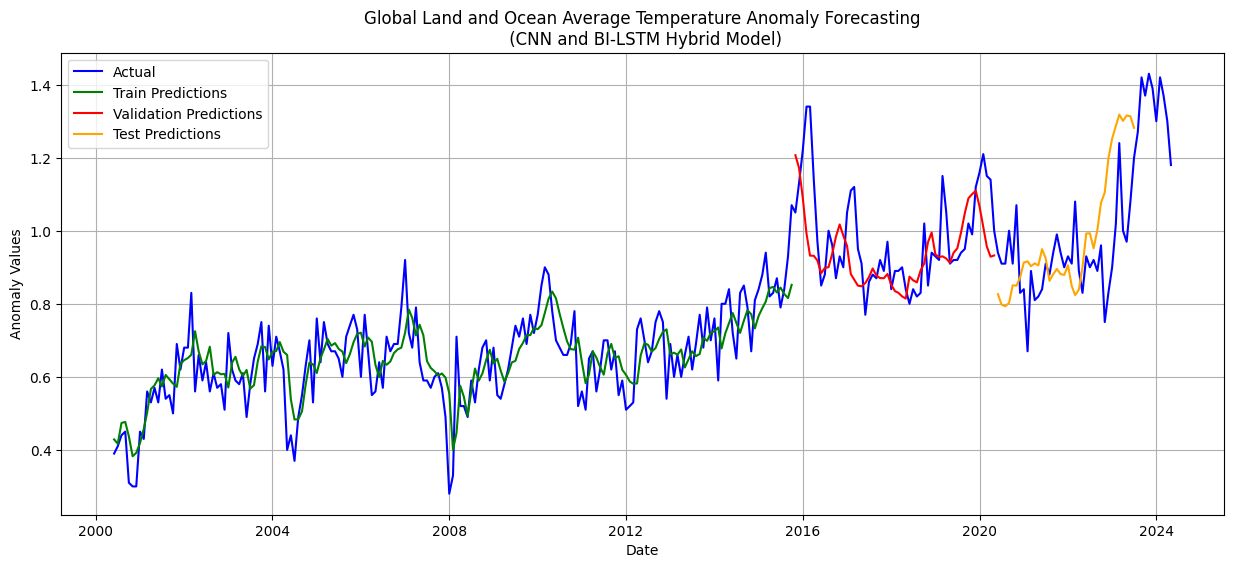

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
train_predictions = model.predict([X_train_cnn, X_train_lstm])
val_predictions = model.predict([X_val_cnn, X_val_lstm])
test_predictions = model.predict([X_test_cnn, X_test_lstm])

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Create a figure for plotting
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(df.index[seq_length:], df['Anomaly'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green')

# Plot validation predictions
val_pred_index = range(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

# Plot test predictions
test_pred_index = range(seq_length + len(train_predictions) + len(val_predictions),
                        seq_length + len(train_predictions) + len(val_predictions) + len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

# Configure plot
plt.title('Global Land and Ocean Average Temperature Anomaly Forecasting\n (CNN and BI-LSTM Hybrid Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')
plt.legend()
plt.grid()  # Optional


In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, Dropout


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # Add dropout layer to prevent overfitting
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.2))  # Add another dropout layer
model.add(Dense(100, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.3095 - val_loss: 0.1915
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1241 - val_loss: 0.0176
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0407 - val_loss: 0.0321
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0304 - val_loss: 0.0252
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0245 - val_loss: 0.0264
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0213 - val_loss: 0.0154
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0210 - val_loss: 0.0165
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0242 - val_loss: 0.0167
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0186 - val_loss: 0.0157
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0179 - val_loss: 0.0150
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - val_loss: 0.0151
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - val_lo

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)
test_predict1 = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict1 = scaler.inverse_transform(test_predict1)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict1)

# Calculate RMSE for training and test sets
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train MSE: 0.0117716567150367
Test MSE: 0.8999620231783215
Train RMSE: 0.10849726593346351
Test RMSE: 0.9486632822968967


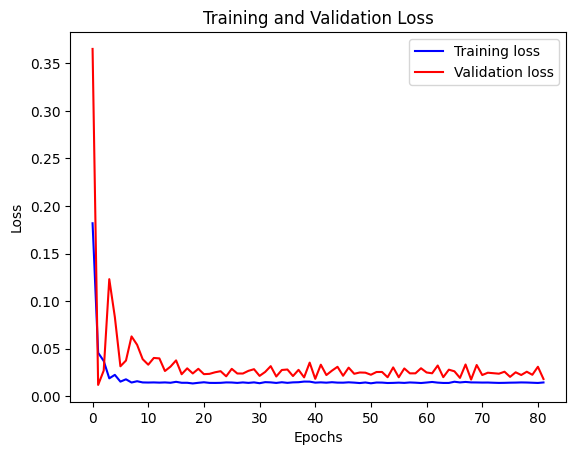

In [ ]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]  # Retrieve validation loss
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")  # Plot validation loss with red color

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



2/2 [==============================] - 0s 12ms/step


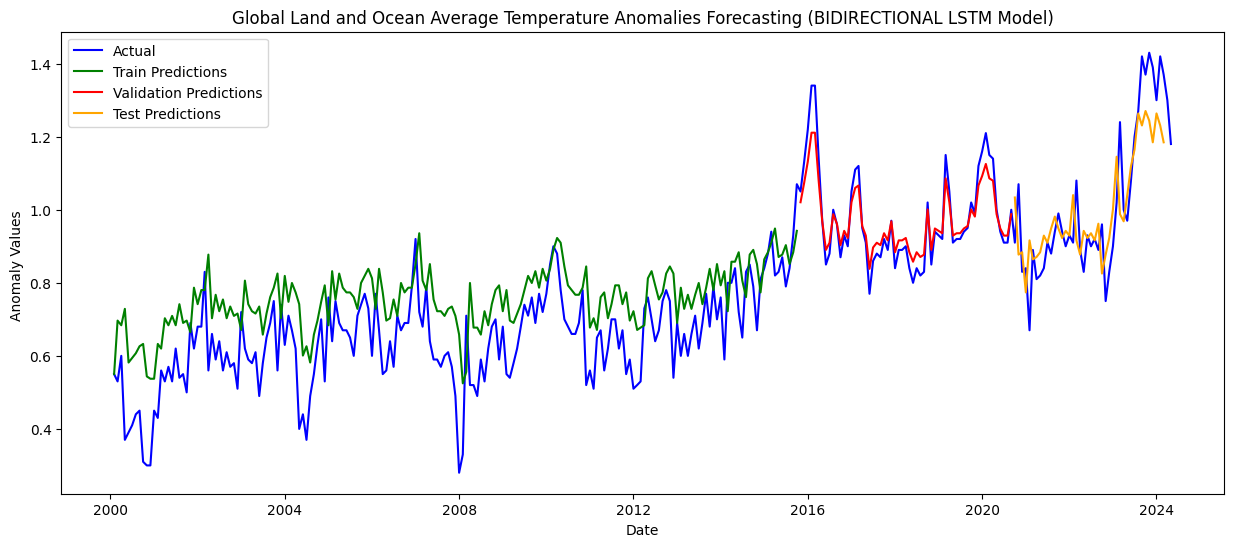

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


plt.figure(figsize=(15, 6))

plt.plot(df.index[seq_length:], df['Anomaly'][seq_length:], label='Actual', color='blue')

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')


val_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

test_pred_index = range(seq_length+len(train_predictions)+len(val_predictions), seq_length+len(train_predictions)+len(val_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

plt.title('Global Land and Ocean Average Temperature Anomalies Forecasting (BIDIRECTIONAL LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values ')
plt.legend()
plt.show()